In [1]:
import numpy as np
import xarray as xr

import matplotlib as mpl
#mpl.use('Agg') # Must be before importing matplotlib.pyplot or pylab!
import matplotlib.pyplot as plt
#import matplotlib.ticker as ticker
from matplotlib import ticker, cm

import pandas as pd
import os
import datetime
#import seaborn as sns
import timeit
import random
from dask.diagnostics import ProgressBar
from functools import partial

#fft packages
from scipy import fftpack
import math
from scipy import fft
from scipy import ndimage
from scipy import signal


In [2]:
#swicth back to plotting defaults
#plt.rcdefaults()


In [3]:
#%% plot parameters
mpl.rcParams['axes.linewidth'] = 2.0 #set the value globally
plt.rc('font', family='serif',size = 18)  # controls default text layout
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize
plt.rc('figure', titlesize=18)  # fontsize of the figure title

#sns.set()
#plt.minorticks_on()

plt.rc('text', usetex=False)


In [4]:
ProgressBar().register()

In [5]:
def _subset_process_time(ds,var,iop):
    
    #subset for the variable(s)
    ds = ds[var]
    ds['time'] = ds.time.dt.round('T')
    #IOP02
    if iop=='iop02': ds['time'] = pd.to_datetime('2019-08-22') + ds['time'].values
    #IOP03
    if iop=='iop03': ds['time'] = pd.to_datetime('2019-09-24') + ds['time'].values
    return(ds)

def _process_time(ds,iop):
    #round time to the nearest minute (30minute for PALM output)
    ds['time'] = ds.time.dt.round('T')
    #IOP02
    if iop=='iop02':ds['time'] = pd.to_datetime('2019-08-22') + ds['time'].values
    #IOP03
    if iop=='iop03':ds['time'] = pd.to_datetime('2019-09-24') + ds['time'].values    
    return(ds)

#function to concatenate all files for an ensemble member and if needed read in all ensemble members
def open_concat_member_files(ensemble_numbers,file,iop):
    data_list = []
    #loop through ensemble members
    if np.size(ensemble_numbers) > 1:
        for member_num in ensemble_numbers:    

            start_time = timeit.default_timer()
            if iop=='iop02': source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP2/ensemble.member.'+str(member_num) 
            #file = 'DATA_3D_AV_NETCDF_N02slice' 

            #Make a folder list and read in all the files from those folders. 
            folder_list = os.listdir(source_folder) 
            folder_list.sort() 
            file_list = [] 
            for folder in folder_list: 
                file_list.append(source_folder + '/' +folder+'/'+file) 
            file_list.sort()
            print(folder_list)

            #combine all the data along the time dimenstion 
            #don't combine them sequentially, but infer the sequence from coordinate values 
            #do this in parallel 
            #pull in only those values with a time dimension 
            var = ['w','theta','q','wtheta','wq']
            partial_func = partial(_subset_process_time, var=var,iop=iop)
            ds = xr.open_mfdataset(file_list,preprocess=partial_func) 
            ds.close() 
            print('Member',str(member_num),'finished collecting data')    
            #subset for time and day and collect into another list
            #for day1
            data_list.append(ds)
            elapsed = timeit.default_timer() - start_time
            print('Done with member',str(member_num),' Time elapsed ',elapsed, 'seconds')
        return(data_list)
            
    else:
        member_num =ensemble_numbers

        #loop through ensemble members
        start_time = timeit.default_timer()
        #IOP02
        if iop=='iop02':source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP2/ensemble.member.'+str(member_num) 
        #IOP03
        if iop=='iop03':source_folder = '/bog/incoming/cheesehead/palm/realistic_runs/ches_IOP03/OUTPUT/ensemble.member.'+str(member_num) 
        
        #file = 'DATA_3D_AV_NETCDF_N03slice' 
        #file = 'DATA_1D_PR_NETCDF_N02slice' 

        #Make a folder list and read in all the files from those folders. 
        folder_list = os.listdir(source_folder) 
        folder_list.sort() 
        file_list = [] 
        for folder in folder_list: 
            file_list.append(source_folder + '/' +folder+'/'+file) 
        file_list.sort()
        print(folder_list)
        
        #combine all the data along the time dimenstion 
        partial_func = partial(_process_time,iop=iop)    
        ds = xr.open_mfdataset(file_list,preprocess=partial_func) 
        ds.close() 
        print('Member',str(member_num),'finished collecting data')    
        #subset for time and day and collect into another list
        #for day1
        #data_list.append(ds)
        elapsed = timeit.default_timer() - start_time
        print('Done with member',str(member_num),' Time elapsed ',elapsed, 'seconds')
        return(ds)

def calculate_turb_flux(ds):
    #subset for the variable(s)
    ds['theta_interpolated'] = ds.theta.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w)
    ds['q_interpolated'] = ds.q.rename({'zu_3d': 'zw_3d'}).interp_like(ds.w)

    ds['wtheta_turb'] = ds['wtheta'] - ds.w*ds.theta_interpolated
    ds['wq_turb'] = ds['wq'] - ds.w*ds.q_interpolated


    ds['wtheta_turb_energy'] = ds['wtheta_turb']*1.17*1005
    ds['wq_turb_energy'] = ds['wq_turb']*1.17*1000*2501

    return ds

#from Luise Wanner
def belltaper(var, n): #-- following Stull 1999
    W = [] # weight function 
    for i in np.arange(n):
        if (i/n > 0.1) & (i/n < 0.9):
            W.append(1)
        else:
            W.append(math.sin(np.pi*i/n)**2)
    out = var * W
    return(out)

def GetPSD1D(psd2D):
    h  = psd2D.shape[0]
    w  = psd2D.shape[1]
    wc = w//2
    hc = h//2

    # create an array of integer radial distances from the center
    Y, X = np.ogrid[0:h, 0:w]
    r    = np.hypot(X - wc, Y - hc).astype(int)

    # SUM all psd2D pixels with label 'r' for 0<=r<=wc
    # NOTE: this will miss power contributions in 'corners' r>wc
    psd1D = ndimage.mean(psd2D, r, index=np.arange(0, wc))

    return psd1D

def open_nc(fname):
    with xr.open_dataset(fname) as ds:
        ds.load()
    
    return ds


#### IOP02

Tower data

In [ ]:
tower_data = xr.open_dataset('tower_and_meta_data_20230505.nc')
tower_data.close()

#calculate time variable and offset for UTC
tower_data['time'] = (tower_data.DOY+tower_data.hour/24+tower_data.minute/60/24 - 5/24)
tower_data['time'] = tower_data['time']
#set local(CDT) time as a coordinate
tower_data = tower_data.set_coords(['time'])

#subset for 2019 Aug 22 and 23
f1 = tower_data.time>=234
f2 = tower_data.time<=236
#subset for 2019 Sep 24 and Sep25
# f1 = tower_data.time>=267
# f2 = tower_data.time<=269

tower_data = tower_data.where(f1 & f2, drop=True)

#subset all >30m towers 
tower_data = tower_data.where(tower_data.z_meas>=30, drop=True)

tower_name_list = tower_data.tower.values

#subset for time, because simulated tower data only start at 5:00 CDT on 23rd and go on till 20:00 on 24
#for IOP02
tower_data = tower_data.isel(timestep=slice(9,88))



In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.subplots(1,1)

ax = tower_data.Qsoil.mean('tower').plot(x='time')

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.subplots(1,1)

ax = tower_data.Tsoil.mean('tower').plot(x='time')

In [ ]:
ensemble_member_ds_N03_iop02 = open_concat_member_files(8,'DATA_3D_NETCDF_N03slice','iop02')
ensemble_member_ds_N03_iop02

In [ ]:
ensemble_member_ds_N03_iop02 = open_concat_member_files(1,'DATA_3D_NETCDF_N03slice','iop02')

x_list = [2217,3981,6159,8619,9225,9669,723,3249,5391,6801,8091,9537]
y_list = [9147,9951,9309,7335,9465,8019,2799,3441,5499,5199,4161,3333]
site_name = ['nw1', 'nw4', 'ne1', 'ne2', 'ne3', 'ne4', 'sw1', 'sw3','sw4', 'se2', 'se3', 'se6']

#list to club all simulated data
site_thetas_list = []
site_qs_list = []


#looping through each site first
for i, site in enumerate(site_name):        

    #list to combine the data for one site
    thetas_list = []
    qs_list = []

    #first collect data at all times for one site

    ds = ensemble_member_ds_N03_iop02.sel(x=x_list[i],y=y_list[i]).sel(zs_3d = slice (0,-0.05))[['m_soil','t_soil']]

    #read in variables to data arrays
    #for each tower location combine the flux data        

    thetas_ds = ds.t_soil.mean('zs_3d')
    qs_ds = ds.m_soil.mean('zs_3d')

    site_thetas_list.append(thetas_ds)
    site_qs_list.append(qs_ds)   

    print('done!' + site)

thetas_all_sites_ds = xr.concat(site_thetas_list, pd.Index(site_name,name='tower')).compute()
qs_all_sites_ds = xr.concat(site_qs_list, pd.Index(site_name,name='tower')).compute()



In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.subplots(1,1)

(thetas_all_sites_ds.mean('tower')-273.15).plot()

In [ ]:
(qs_all_sites_ds.mean('tower')*100).plot()

They look good :) the match is not bad and I'm releived. 

## Representative plots for surface fluxes for iop02 and iop03

iop02 data

In [ ]:
ensemble_member_ds_2_P_iop02 = open_concat_member_files(2,'DATA_3D_AV_NETCDFslice','iop02')
ensemble_member_ds_2_N02_iop02 = open_concat_member_files(2,'DATA_3D_AV_NETCDF_N02slice','iop02')
ensemble_member_ds_2_N03_iop02 = open_concat_member_files(2,'DATA_3D_AV_NETCDF_N03slice','iop02')

iop03 data

In [ ]:
ensemble_member_ds_2_P_iop03 = open_concat_member_files(2,'DATA_3D_AV_NETCDFslice','iop03')
ensemble_member_ds_2_N02_iop03 = open_concat_member_files(2,'DATA_3D_AV_NETCDF_N02slice','iop03')
ensemble_member_ds_2_N03_iop03 = open_concat_member_files(2,'DATA_3D_AV_NETCDF_N03slice','iop03')

iop02 surface data

In [ ]:
ensemble_member_surf_ds_2_P_iop02 = open_concat_member_files(2,'DATA_2D_XY_AV_NETCDFslice','iop02')
ensemble_member_surf_ds_2_N02_iop02 = open_concat_member_files(2,'DATA_2D_XY_AV_NETCDF_N02slice','iop02')
ensemble_member_surf_ds_2_N03_iop02 = open_concat_member_files(2,'DATA_2D_XY_AV_NETCDF_N03slice','iop02')

iop03 surface data

In [ ]:
ensemble_member_surf_ds_2_P_iop03 = open_concat_member_files(2,'DATA_2D_XY_AV_NETCDFslice','iop03')
ensemble_member_surf_ds_2_N02_iop03 = open_concat_member_files(2,'DATA_2D_XY_AV_NETCDF_N02slice','iop03')
ensemble_member_surf_ds_2_N03_iop03 = open_concat_member_files(2,'DATA_2D_XY_AV_NETCDF_N03slice','iop03')

Total surface fluxes:

In [ ]:
ensemble_member_ds_2_N03_iop02

For Luise: Sum of PCM and surface fluxes, cross sections.

In [ ]:
###---------------------------------------------------
#PCM fluxes in the domains

N03_H_PCM = (ensemble_member_ds_2_N03_iop02.pcm_heatrate.sel(time='2019-08-23T12:00:00.000000000').sum('zpc_3d')*1.17*1005*4)

N03_LE_PCM = (ensemble_member_ds_2_N03_iop02.pcm_transpirationrate.sel(time='2019-08-23T12:00:00.000000000').sum('zpc_3d')*2.5E+06 * 1.17*4)


###---------------------------------------------------
#surface fluxes in the domains
N03_H_surf = ensemble_member_surf_ds_2_N03_iop02['shf*_xy'].isel(time=71)

N03_LE_surf = ensemble_member_surf_ds_2_N03_iop02['qsws*_xy'].isel(time=71)

###---------------------------------------------------

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,12))

(N03_H_surf+N03_H_PCM).plot(ax=ax1,cmap='OrRd',vmin=0,vmax=900,cbar_kwargs={'location':'bottom'})
(N03_LE_surf+N03_LE_PCM).plot(ax=ax2,cmap='OrRd',vmin=0,vmax=600,cbar_kwargs={'location':'bottom'})#,vmin=0,vmax=400,


I'll just extract the time series for surface forcings at the tower locations

In [ ]:
#setting the iop and ensemble numbers needed
iop = 'iop02' 
ensemble_numbers = np.arange(1,9)

#loop through each member,
#extract and concatenate the data
#extract profile data at each tower location
#calculate the turbulent fluxes and extract theta,q 
#output an xarray data array per each ensemble member and then concatenate it outside of the loop
wtheta_all_members_list = []
wq_all_members_list = []

for member_num in ensemble_numbers:
    
    ensemble_member_ds_N03_iop02 = open_concat_member_files(member_num,'DATA_3D_AV_NETCDF_N03slice',iop)
    ensemble_member_surf_ds_N03_iop02 = open_concat_member_files(member_num,'DATA_2D_XY_AV_NETCDF_N03slice',iop)

    x_list = [2217,3981,6159,8619,9225,9669,723,3249,5391,6801,8091,9537]
    y_list = [9147,9951,9309,7335,9465,8019,2799,3441,5499,5199,4161,3333]
    site_name = ['nw1', 'nw4', 'ne1', 'ne2', 'ne3', 'ne4', 'sw1', 'sw3','sw4', 'se2', 'se3', 'se6']

    site_wtheta_list = []
    site_wq_list = []


    #looping through each site first
    for i, site in enumerate(site_name):        

        #list to combine the data for one site
        wtheta_list = []
        wq_list = []

        #first collect data at all times for one site

        ds_PCM = ensemble_member_ds_N03_iop02.sel(x=x_list[i],y=y_list[i])
        ds_surf = ensemble_member_surf_ds_N03_iop02.sel(x=x_list[i],y=y_list[i])

        #PCM fluxes in the domains

        N03_H_PCM = (ds_PCM.pcm_heatrate.sum('zpc_3d')*1.17*1005*4)

        N03_LE_PCM = (ds_PCM.pcm_transpirationrate.sum('zpc_3d')*2.5E+06 * 1.17*4)


        ###---------------------------------------------------
        #surface fluxes in the domains
        N03_H_surf = ds_surf['shf*_xy']

        N03_LE_surf = ds_surf['qsws*_xy']


        wtheta_ds = (N03_H_PCM + N03_H_surf)
        wq_ds = (N03_LE_PCM + N03_LE_surf)

        
        site_wtheta_list.append(wtheta_ds)
        site_wq_list.append(wq_ds)   

        print('done!' + site)

    wtheta_all_sites_ds = xr.concat(site_wtheta_list, pd.Index(site_name,name='tower')).compute()
    wq_all_sites_ds = xr.concat(site_wq_list, pd.Index(site_name,name='tower')).compute()
    
    wtheta_all_members_list.append(wtheta_all_sites_ds)
    wq_all_members_list.append(wq_all_sites_ds)
    
    print('done member' + str(member_num) + '!')


In [ ]:
# xr.concat(wtheta_all_members_list,'ensemble').to_netcdf('work/wtheta_surface_all_members.nc')
# xr.concat(wq_all_members_list,'ensemble').to_netcdf('work/wq_surface_all_members.nc')


Read in 

In [ ]:
wtheta_surface_simulated = open_nc('work/wtheta_surface_all_members.nc')
wtheta_surface_simulated['wtheta_surface'] = wtheta_surface_simulated['__xarray_dataarray_variable__'].rename('wtheta_surface')
wtheta_surface_simulated = wtheta_surface_simulated.drop(['__xarray_dataarray_variable__'])

wq_surface_simulated = open_nc('work/wq_surface_all_members.nc')
wq_surface_simulated['wq_surface'] = wq_surface_simulated['__xarray_dataarray_variable__'].rename('wq_surface')
wq_surface_simulated = wq_surface_simulated.drop(['__xarray_dataarray_variable__'])


In [ ]:

fig = plt.figure(figsize=(10,5))
ax = fig.subplots(1,1)
for tower_name in wtheta_surface_simulated.tower:
    wtheta_surface_simulated.wtheta_surface.mean('ensemble').sel(tower=tower_name.values).plot(ax=ax,label=str(tower_name.values),x='time')

wtheta_surface_simulated.wtheta_surface.mean('ensemble').mean('tower').plot(ax=ax,color ='black',x='time')

fig.legend(loc=7,fontsize=12)
ax.set_xlabel('Time',fontsize=18)
ax.set_ylabel('wtheta surface simulated (W/m2)',fontsize=18)
#ax.set_ylim([-0.25,0.3])
ax.grid(True)
fig.legend(loc=7,fontsize=12)
fig.tight_layout()
fig.subplots_adjust(right=0.8)


In [ ]:

fig = plt.figure(figsize=(10,5))
ax = fig.subplots(1,1)
for tower_name in wtheta_surface_simulated.tower:
    wq_surface_simulated.wq_surface.mean('ensemble').sel(tower=tower_name.values).plot(ax=ax,label=str(tower_name.values),x='time')

wq_surface_simulated.wq_surface.mean('ensemble').mean('tower').plot(ax=ax,color ='black',x='time')

fig.legend(loc=7,fontsize=12)
ax.set_xlabel('Time',fontsize=18)
ax.set_ylabel('wq surface simulated (W/m2)',fontsize=18)
#ax.set_ylim([-0.25,0.3])
ax.grid(True)
fig.legend(loc=7,fontsize=12)
fig.tight_layout()
fig.subplots_adjust(right=0.8)


In [ ]:
wtheta_simulated = open_nc('work/wtheta_all_members_IOP02.nc')
wq_simulated = open_nc('work/wq_all_members_IOP02.nc')
wtheta_simulated['time']= wtheta_simulated.time - pd.Timedelta(1, unit='D')
wq_simulated['time']= wq_simulated.time - pd.Timedelta(1, unit='D')

Simulated SEB residual: surface-tower height, at tower locations

In [ ]:
mean_surface_H = wtheta_surface_simulated.wtheta_surface.mean('ensemble').mean('tower')
mean_surface_LE = wq_surface_simulated.wq_surface.mean('ensemble').mean('tower')

mean_H = wtheta_simulated.wtheta_turb_energy.mean('ensemble').mean('tower')
mean_LE = wq_simulated.wq_turb_energy.mean('ensemble').mean('tower')

H_missing = mean_surface_H - mean_H
LE_missing = mean_surface_LE - mean_LE


In [ ]:

fig = plt.figure(figsize=(10,5))
ax = fig.subplots(1,1)

H_missing.plot(ax=ax,color ='red',x='time')
LE_missing.plot(ax=ax,color ='blue',x='time')

fig.legend(loc=7,fontsize=12)
ax.set_xlabel('Time',fontsize=18)
ax.set_ylabel('SEB missing (W/m2)',fontsize=18)
#ax.set_ylim([-0.25,0.3])
ax.grid(True)
fig.legend(loc=7,fontsize=12)
fig.tight_layout()
fig.subplots_adjust(right=0.8)

In [ ]:

fig = plt.figure(figsize=(10,5))
ax = fig.subplots(1,1)

(H_missing+LE_missing).plot(ax=ax,color ='black',x='time')

fig.legend(loc=7,fontsize=12)
ax.set_xlabel('Time',fontsize=18)
ax.set_ylabel('SEB missing (W/m2)',fontsize=18)
#ax.set_ylim([-0.25,0.3])
ax.grid(True)
fig.legend(loc=7,fontsize=12)
fig.tight_layout()
fig.subplots_adjust(right=0.8)

The really high values for H is very weird. I should check flux profiles, with absolute magnitudes tomorrow firstly.

See how much of dispersive flux transport exists between H and LE in absolute magnitudes..

As MS suggested, it could be that not all of this heat goes into the atmosphere, some of it goes to soil and then to canopy heat storage.

Checking ground heat flux.

In [ ]:
ensemble_member_surf_ds_N03_iop02

In [ ]:
#setting the iop and ensemble numbers needed
iop = 'iop02' 
ensemble_numbers = np.arange(1,9)

#loop through each member,
#extract and concatenate the data
#output an xarray data array per each ensemble member and then concatenate it outside of the loop
ghf_all_members_list = []

for member_num in ensemble_numbers:
    
    ensemble_member_surf_ds_N03_iop02 = open_concat_member_files(member_num,'DATA_2D_XY_AV_NETCDF_N03slice',iop)

    x_list = [2217,3981,6159,8619,9225,9669,723,3249,5391,6801,8091,9537]
    y_list = [9147,9951,9309,7335,9465,8019,2799,3441,5499,5199,4161,3333]
    site_name = ['nw1', 'nw4', 'ne1', 'ne2', 'ne3', 'ne4', 'sw1', 'sw3','sw4', 'se2', 'se3', 'se6']

    site_ghf_list = []


    #looping through each site first
    for i, site in enumerate(site_name):        


        #first collect data at all times for one site

        ds_surf = ensemble_member_surf_ds_N03_iop02.sel(x=x_list[i],y=y_list[i])

        #surface fluxes in the domains
        ghf_ds = ds_surf['ghf*_xy']
        
        site_ghf_list.append(ghf_ds)
        print('done!' + site)

    ghf_all_sites_ds = xr.concat(site_ghf_list, pd.Index(site_name,name='tower')).compute()
    
    ghf_all_members_list.append(ghf_all_sites_ds)    
    print('done member' + str(member_num) + '!')

In [ ]:
# xr.concat(ghf_all_members_list,'ensemble').to_netcdf('work/ghf_all_members_list.nc')


In [ ]:
ghf_simulated = open_nc('work/ghf_all_members_list.nc')


In [ ]:

fig = plt.figure(figsize=(10,5))
ax = fig.subplots(1,1)

ghf_simulated['ghf*_xy'].mean('ensemble').mean('tower').plot(ax=ax,color ='black',x='time')

fig.legend(loc=7,fontsize=12)
ax.set_xlabel('Time',fontsize=18)
ax.set_ylabel('SEB missing (W/m2)',fontsize=18)
#ax.set_ylim([-0.25,0.3])
ax.grid(True)
fig.legend(loc=7,fontsize=12)
fig.tight_layout()
fig.subplots_adjust(right=0.8)

Just by itself this makes sense, but doesn't help our case. Buttt, indications that we should do proper flux budgets at canopy top...

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.subplots(1,1)

(H_missing+LE_missing-ghf_simulated['ghf*_xy'].mean('ensemble').mean('tower')).plot(ax=ax,color ='black',x='time')

fig.legend(loc=7,fontsize=12)
ax.set_xlabel('Time',fontsize=18)
ax.set_ylabel('SEB missing (W/m2)',fontsize=18)
#ax.set_ylim([-0.25,0.3])
ax.grid(True)
fig.legend(loc=7,fontsize=12)
fig.tight_layout()
fig.subplots_adjust(right=0.8)

This looks like a more reasonable daytime magnitude..

Maybe make a time series of the dispersive fluxes. won't be so much..

In [ ]:
ensemble_member_ds_N03_iop02 = open_concat_member_files(member_num,'DATA_3D_AV_NETCDF_N03slice',iop)
ensemble_member_ds_N03_iop02

In [ ]:
w = ensemble_member_ds_N03_iop02.w.sel(zw_3d=36)
theta = ensemble_member_ds_N03_iop02.theta.sel(zu_3d=34)
q = ensemble_member_ds_N03_iop02.q.sel(zu_3d=34)

In [ ]:
w = ensemble_member_ds_2_N03_iop03.w.sel(zw_3d=36)
theta = ensemble_member_ds_2_N03_iop03.theta.sel(zu_3d=34)
q = ensemble_member_ds_2_N03_iop03.q.sel(zu_3d=34)

In [ ]:
wtheta_dispersive = ((w - w.mean('x').mean('y'))*(theta - theta.mean('x').mean('y'))).mean('x').mean('y')
wtheta_dispersive = wtheta_dispersive*1.17*1005

wq_dispersive = ((w - w.mean('x').mean('y'))*(q - q.mean('x').mean('y'))).mean('x').mean('y')
wq_dispersive = wq_dispersive*1.17*1005*2501


In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.subplots(1,1)

(wtheta_dispersive).plot(ax=ax,color ='red',x='time', label = 'H ')
(wq_dispersive).plot(ax=ax,color ='blue',x='time', label = 'LE ')

(wtheta_dispersive+wq_dispersive).plot(ax=ax,color ='black',x='time', label = 'Total')

fig.legend(loc=7,fontsize=12)
ax.set_xlabel('Time',fontsize=18)
ax.set_ylabel('Dispersive fluxes (W/m2)',fontsize=18)
ax.grid(True)
fig.legend(loc=7,fontsize=12)
fig.tight_layout()
fig.subplots_adjust(right=0.8)

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = fig.subplots(1,1)

(wtheta_dispersive).plot(ax=ax,color ='red',x='time', label = 'H ')
(wq_dispersive).plot(ax=ax,color ='blue',x='time', label = 'LE ')

(wtheta_dispersive+wq_dispersive).plot(ax=ax,color ='black',x='time', label = 'Total')

fig.legend(loc=7,fontsize=12)
ax.set_xlabel('Time',fontsize=18)
ax.set_ylabel('Dispersive fluxes (W/m2)',fontsize=18)
#ax.set_ylim([-0.25,0.3])
ax.grid(True)
fig.legend(loc=7,fontsize=12)
fig.tight_layout()
fig.subplots_adjust(right=0.8)

## Horizontal advective flux and dispersive flux budgets for differing control volumes around the tall tower. 

In [19]:

#open 3d avg data for ensemble member 2
member_num = 2
iop = 'iop02'
ensemble_member_ds_N03_iop02 = open_concat_member_files(member_num,'DATA_3D_AV_NETCDF_N03slice',iop)

#find the location of PFa
x_list = [6075]
y_list = [6183]
i = 0
ds = ensemble_member_ds_N03_iop02.sel(time=slice('2019-08-23T08:00:00.000000000','2019-08-23T20:00:00.000000000'),
                                     zu_3d = slice(0,36),
                                     zw_3d = slice(0,36))

ds['theta_interpolated_u'] = ds.theta.rename({'x': 'xu'}).interp_like(ds.u).compute()
ds['theta_interpolated_v'] = ds.theta.rename({'y': 'yv'}).interp_like(ds.v).compute()

ds['q_interpolated_u'] = ds.q.rename({'x': 'xu'}).interp_like(ds.u).compute()
ds['q_interpolated_v'] = ds.q.rename({'y': 'yv'}).interp_like(ds.v).compute()

#read in variables to data arrays
#for each tower location combine the flux data        

# wtheta_ds = ds.wtheta_turb_energy.sel(zw_3d=32)
# wq_ds = ds.wq_turb_energy.sel(zw_3d=32)

#set up a box of 5 km horizontal extent and average and see what happens?



['01.ches_IOP2.20255', '02.ches_IOP2.13449', '03.ches_IOP2.733', '04.ches_IOP2.18198', '05.ches_IOP2.19794', '06.ches_IOP2.11638', '07.ches_IOP02.31113']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.37764085084199905 seconds
[########################################] | 100% Completed | 156.99 s
[########################################] | 100% Completed | 135.09 s
[########################################] | 100% Completed | 155.68 s
[########################################] | 100% Completed | 174.31 s


In [23]:
ensemble_member_ds_N03_iop02

<xarray.Dataset>
Dimensions:                (x: 2000, time: 88, y: 2000, xu: 2000, yv: 2000,
                            zu_3d: 27, zw_3d: 27, zpc_3d: 10)
Coordinates:
  * x                      (x) float64 3.0 9.0 15.0 ... 1.199e+04 1.2e+04
  * y                      (y) float64 3.0 9.0 15.0 ... 1.199e+04 1.2e+04
  * xu                     (xu) float64 0.0 6.0 12.0 ... 1.199e+04 1.199e+04
  * yv                     (yv) float64 0.0 6.0 12.0 ... 1.199e+04 1.199e+04
  * time                   (time) datetime64[ns] 2019-08-22T00:30:00 ... 2019...
  * zu_3d                  (zu_3d) float64 0.0 2.0 6.0 10.0 ... 94.0 98.0 102.0
  * zw_3d                  (zw_3d) float64 0.0 4.0 8.0 12.0 ... 96.0 100.0 104.0
  * zpc_3d                 (zpc_3d) float64 0.0 2.0 6.0 10.0 ... 26.0 30.0 34.0
Data variables: (12/35)
    E_UTM                  (time, x) float64 dask.array<chunksize=(14, 2000), meta=np.ndarray>
    N_UTM                  (time, y) float64 dask.array<chunksize=(14, 2000), meta=np.ndarray>
    Eu_UTM                 (time, xu) float64 dask.array<chunksize=(14, 2000), meta=np.ndarray>
    Nu_UTM                 (time, y) float64 dask.array<chunksize=(14, 2000), meta=np.ndarray>
    Ev_UTM                 (time, x) float64 dask.array<chunksize=(14, 2000), meta=np.ndarray>
    Nv_UTM                 (time, yv) float64 dask.array<chunksize=(14, 2000), meta=np.ndarray>
    ...                     ...
    wtheta                 (time, zw_3d, y, x) float32 dask.array<chunksize=(14, 27, 2000, 2000), meta=np.ndarray>
    wq                     (time, zw_3d, y, x) float32 dask.array<chunksize=(14, 27, 2000, 2000), meta=np.ndarray>
    ws                     (time, zw_3d, y, x) float32 dask.array<chunksize=(14, 27, 2000, 2000), meta=np.ndarray>
    pcm_heatrate           (time, zpc_3d, y, x) float32 dask.array<chunksize=(14, 10, 2000, 2000), meta=np.ndarray>
    pcm_transpirationrate  (time, zpc_3d, y, x) float32 dask.array<chunksize=(14, 10, 2000, 2000), meta=np.ndarray>
    pcm_latentrate         (time, zpc_3d, y, x) float32 dask.array<chunksize=(14, 10, 2000, 2000), meta=np.ndarray>
Attributes: (12/28)
    title:           PALM 21.10-rc.2  run: ches_IOP2.01  nest-id: 03  host: b...
    Conventions:     CF-1.7
    creation_time:   2022-08-16 02:54:38 -06
    data_content:    3d_av
    version:         2
    origin_time:     2019-08-22 05:00:00 +00
    ...              ...
    references:      
    keywords:        example, PALM-4U
    licence:         
    comment:         Generic crossing example
    time_avg:         1800.0 s avg
    VAR_LIST:        ;u;v;w;e;uu;vv;ww;uv;uw;vw;theta;q;s;rh;wtheta;wq;ws;pcm...

In [20]:
#calculate the horizontal advective flux for a given box size centered around this location now
# flux formulation is sum(spatial_mean(time_mean(horizontal_velocity))*spatial_mean(time_mean(scalar)))
#subset dataset for the box
length = 5000
ds = ds.sel(x=slice(x_list[i]-length/2,x_list[i]+length/2),
                                      xu=slice(x_list[i]-length/2,x_list[i]+length/2),
                                      y=slice(y_list[i]-length/2,y_list[i]+length/2),
                                      yv=slice(y_list[i]-length/2,y_list[i]+length/2))


In [38]:
ds

<xarray.Dataset>
Dimensions:                (x: 833, time: 25, y: 833, xu: 834, yv: 834,
                            zu_3d: 10, zw_3d: 10, zpc_3d: 10)
Coordinates:
  * x                      (x) float64 3.579e+03 3.585e+03 ... 8.571e+03
  * y                      (y) float64 3.687e+03 3.693e+03 ... 8.679e+03
  * xu                     (xu) float64 3.576e+03 3.582e+03 ... 8.574e+03
  * yv                     (yv) float64 3.684e+03 3.69e+03 ... 8.682e+03
  * time                   (time) datetime64[ns] 2019-08-23T08:00:00 ... 2019...
  * zu_3d                  (zu_3d) float64 0.0 2.0 6.0 10.0 ... 26.0 30.0 34.0
  * zw_3d                  (zw_3d) float64 0.0 4.0 8.0 12.0 ... 28.0 32.0 36.0
  * zpc_3d                 (zpc_3d) float64 0.0 2.0 6.0 10.0 ... 26.0 30.0 34.0
Data variables: (12/39)
    E_UTM                  (time, x) float64 dask.array<chunksize=(4, 833), meta=np.ndarray>
    N_UTM                  (time, y) float64 dask.array<chunksize=(4, 833), meta=np.ndarray>
    Eu_UTM                 (time, xu) float64 dask.array<chunksize=(4, 834), meta=np.ndarray>
    Nu_UTM                 (time, y) float64 dask.array<chunksize=(4, 833), meta=np.ndarray>
    Ev_UTM                 (time, x) float64 dask.array<chunksize=(4, 833), meta=np.ndarray>
    Nv_UTM                 (time, yv) float64 dask.array<chunksize=(4, 834), meta=np.ndarray>
    ...                     ...
    pcm_transpirationrate  (time, zpc_3d, y, x) float32 dask.array<chunksize=(4, 10, 833, 833), meta=np.ndarray>
    pcm_latentrate         (time, zpc_3d, y, x) float32 dask.array<chunksize=(4, 10, 833, 833), meta=np.ndarray>
    theta_interpolated_u   (time, zu_3d, y, xu) float64 nan nan ... 295.2 295.2
    theta_interpolated_v   (time, zu_3d, yv, x) float64 nan nan ... 295.2 295.2
    q_interpolated_u       (time, zu_3d, y, xu) float64 nan nan ... 0.007054
    q_interpolated_v       (time, zu_3d, yv, x) float64 nan nan ... 0.007057
Attributes: (12/28)
    title:           PALM 21.10-rc.2  run: ches_IOP2.01  nest-id: 03  host: b...
    Conventions:     CF-1.7
    creation_time:   2022-08-16 02:54:38 -06
    data_content:    3d_av
    version:         2
    origin_time:     2019-08-22 05:00:00 +00
    ...              ...
    references:      
    keywords:        example, PALM-4U
    licence:         
    comment:         Generic crossing example
    time_avg:         1800.0 s avg
    VAR_LIST:        ;u;v;w;e;uu;vv;ww;uv;uw;vw;theta;q;s;rh;wtheta;wq;ws;pcm...

I've to remove the imposed large scale velocities and theta and q.

In [7]:
pwd() 

'/bog/incoming/CHEESEHEAD/palm/realistic_runs/python_scripts/spaleri'

In [31]:
ches_dynamic_ds = xr.open_dataset('/bog/incoming/CHEESEHEAD/palm/realistic_runs/ches_IOP2/INPUT/ches_IOP2_dynamic')
ches_dynamic_ds.close()

In [9]:
ches_dynamic_ds_N02 = xr.open_dataset('/bog/incoming/CHEESEHEAD/palm/realistic_runs/ches_IOP2/INPUT/ches_IOP2_dynamic_N02')
ches_dynamic_ds_N02.close()

In [26]:
ches_dynamic_ds

<xarray.Dataset>
Dimensions:                           (z: 296, time: 49, x: 540, y: 576,
                                       zw: 295, zsoil: 8, time_rad: 49,
                                       xu: 539, yv: 575)
Coordinates:
  * z                                 (z) float64 6.0 18.0 ... 5.147e+03
  * time                              (time) float64 0.0 3.6e+03 ... 1.728e+05
  * x                                 (x) float64 45.0 135.0 ... 4.856e+04
  * y                                 (y) float64 45.0 135.0 ... 5.18e+04
  * zw                                (zw) float64 12.0 24.0 ... 5.117e+03
  * zsoil                             (zsoil) float64 0.01 0.02 ... 0.54 1.86
  * time_rad                          (time_rad) float64 0.0 ... 1.728e+05
  * xu                                (xu) float64 90.0 180.0 ... 4.851e+04
  * yv                                (yv) float64 90.0 180.0 ... 5.175e+04
Data variables: (12/39)
    rad_lw_in                         (time_rad) float32 ...
    rad_sw_in                         (time_rad) float32 ...
    init_soil_m                       (zsoil, y, x) float64 ...
    init_soil_t                       (zsoil, y, x) float64 ...
    init_atmosphere_pt                (z) float64 ...
    ls_forcing_left_pt                (time, z) float64 ...
    ...                                ...
    ls_forcing_top_w                  (time) float64 ...
    surface_forcing_surface_pressure  (time) float32 ...
    ls_forcing_ug                     (time, z) float64 ...
    ls_forcing_vg                     (time, z) float64 ...
    CO2                               (time, y, x) float64 ...
    init_atmosphere_CO2               (z) float64 ...
Attributes:
    description:     Contains dynamic data from NCEP HRRR mesoscale. HRRR out...
    author:          Sreenath Paleri (paleri@wisc.edu)
    history:         Created at Mon Apr 11 07:47:49 2022
    source:          netCDF4 python
    origin_lat:      45.945
    origin_lon:      -90.28
    z:               0.0
    x:               0.0
    y:               0.0
    rotation_angle:  0.0
    origin_time:     2019-08-22 05:00:00 UTC
    end_time:        2019-08-24 05:00:00 UTC

In [32]:
ches_dynamic_ds = ches_dynamic_ds.assign_coords(date_time=('time',pd.to_datetime(ches_dynamic_ds['time']*1E9,origin=pd.Timestamp('2019-08-22'))))
#set the new dimension along the old 'time' dimension so that we can plot all the data variables along the new dimension
ches_dynamic_ds = ches_dynamic_ds.swap_dims({"time": "date_time"})
ches_dynamic_ds = ches_dynamic_ds.drop_vars('time').rename({'date_time':'time'})
ches_dynamic_ds

<xarray.Dataset>
Dimensions:                           (z: 296, x: 540, y: 576, zw: 295,
                                       zsoil: 8, time_rad: 49, xu: 539,
                                       yv: 575, time: 49)
Coordinates:
  * z                                 (z) float64 6.0 18.0 ... 5.147e+03
  * x                                 (x) float64 45.0 135.0 ... 4.856e+04
  * y                                 (y) float64 45.0 135.0 ... 5.18e+04
  * zw                                (zw) float64 12.0 24.0 ... 5.117e+03
  * zsoil                             (zsoil) float64 0.01 0.02 ... 0.54 1.86
  * time_rad                          (time_rad) float64 0.0 ... 1.728e+05
  * xu                                (xu) float64 90.0 180.0 ... 4.851e+04
  * yv                                (yv) float64 90.0 180.0 ... 5.175e+04
  * time                              (time) datetime64[ns] 2019-08-22 ... 20...
Data variables: (12/39)
    rad_lw_in                         (time_rad) float32 ...
    rad_sw_in                         (time_rad) float32 ...
    init_soil_m                       (zsoil, y, x) float64 ...
    init_soil_t                       (zsoil, y, x) float64 ...
    init_atmosphere_pt                (z) float64 ...
    ls_forcing_left_pt                (time, z) float64 ...
    ...                                ...
    ls_forcing_top_w                  (time) float64 ...
    surface_forcing_surface_pressure  (time) float32 ...
    ls_forcing_ug                     (time, z) float64 ...
    ls_forcing_vg                     (time, z) float64 ...
    CO2                               (time, y, x) float64 ...
    init_atmosphere_CO2               (z) float64 ...
Attributes:
    description:     Contains dynamic data from NCEP HRRR mesoscale. HRRR out...
    author:          Sreenath Paleri (paleri@wisc.edu)
    history:         Created at Mon Apr 11 07:47:49 2022
    source:          netCDF4 python
    origin_lat:      45.945
    origin_lon:      -90.28
    z:               0.0
    x:               0.0
    y:               0.0
    rotation_angle:  0.0
    origin_time:     2019-08-22 05:00:00 UTC
    end_time:        2019-08-24 05:00:00 UTC

I should get the imposed wind and scalar profiles and interpolate them to the N02 grid


In [41]:
ches_dynamic_ds_subset = ches_dynamic_ds.sel(time=slice('2019-08-23T08:00:00.000000000','2019-08-23T20:00:00.000000000'))[['ls_forcing_left_u','ls_forcing_left_v','ls_forcing_left_pt','ls_forcing_left_qv']].rename({'z':'zu_3d'})

In [43]:
ensemble_member_ds_N03_iop02

<xarray.Dataset>
Dimensions:                (x: 2000, time: 88, y: 2000, xu: 2000, yv: 2000,
                            zu_3d: 27, zw_3d: 27, zpc_3d: 10)
Coordinates:
  * x                      (x) float64 3.0 9.0 15.0 ... 1.199e+04 1.2e+04
  * y                      (y) float64 3.0 9.0 15.0 ... 1.199e+04 1.2e+04
  * xu                     (xu) float64 0.0 6.0 12.0 ... 1.199e+04 1.199e+04
  * yv                     (yv) float64 0.0 6.0 12.0 ... 1.199e+04 1.199e+04
  * time                   (time) datetime64[ns] 2019-08-22T00:30:00 ... 2019...
  * zu_3d                  (zu_3d) float64 0.0 2.0 6.0 10.0 ... 94.0 98.0 102.0
  * zw_3d                  (zw_3d) float64 0.0 4.0 8.0 12.0 ... 96.0 100.0 104.0
  * zpc_3d                 (zpc_3d) float64 0.0 2.0 6.0 10.0 ... 26.0 30.0 34.0
Data variables: (12/35)
    E_UTM                  (time, x) float64 dask.array<chunksize=(14, 2000), meta=np.ndarray>
    N_UTM                  (time, y) float64 dask.array<chunksize=(14, 2000), meta=np.ndarray>
    Eu_UTM                 (time, xu) float64 dask.array<chunksize=(14, 2000), meta=np.ndarray>
    Nu_UTM                 (time, y) float64 dask.array<chunksize=(14, 2000), meta=np.ndarray>
    Ev_UTM                 (time, x) float64 dask.array<chunksize=(14, 2000), meta=np.ndarray>
    Nv_UTM                 (time, yv) float64 dask.array<chunksize=(14, 2000), meta=np.ndarray>
    ...                     ...
    wtheta                 (time, zw_3d, y, x) float32 dask.array<chunksize=(14, 27, 2000, 2000), meta=np.ndarray>
    wq                     (time, zw_3d, y, x) float32 dask.array<chunksize=(14, 27, 2000, 2000), meta=np.ndarray>
    ws                     (time, zw_3d, y, x) float32 dask.array<chunksize=(14, 27, 2000, 2000), meta=np.ndarray>
    pcm_heatrate           (time, zpc_3d, y, x) float32 dask.array<chunksize=(14, 10, 2000, 2000), meta=np.ndarray>
    pcm_transpirationrate  (time, zpc_3d, y, x) float32 dask.array<chunksize=(14, 10, 2000, 2000), meta=np.ndarray>
    pcm_latentrate         (time, zpc_3d, y, x) float32 dask.array<chunksize=(14, 10, 2000, 2000), meta=np.ndarray>
Attributes: (12/28)
    title:           PALM 21.10-rc.2  run: ches_IOP2.01  nest-id: 03  host: b...
    Conventions:     CF-1.7
    creation_time:   2022-08-16 02:54:38 -06
    data_content:    3d_av
    version:         2
    origin_time:     2019-08-22 05:00:00 +00
    ...              ...
    references:      
    keywords:        example, PALM-4U
    licence:         
    comment:         Generic crossing example
    time_avg:         1800.0 s avg
    VAR_LIST:        ;u;v;w;e;uu;vv;ww;uv;uw;vw;theta;q;s;rh;wtheta;wq;ws;pcm...

In [45]:
test_data = ensemble_member_ds_N03_iop02.u.sel(time=slice('2019-08-23T08:00:00.000000000','2019-08-23T20:00:00.000000000')).mean('y').mean('xu').compute()

[########################################] | 100% Completed | 17.02 s


In [48]:
ches_dynamic_ds_subset = ches_dynamic_ds_subset.interp_like(test_data)

In [98]:
ches_dynamic_ds_subset['ls_forcing_left_u']

<xarray.DataArray 'ls_forcing_left_u' (time: 25, zu_3d: 27)>
array([[        nan,         nan, -0.75518608, -0.7924039 , -0.82962171,
        -0.86683953, -0.90405736, -0.9412752 , -0.97849303, -1.01571083,
        -1.05292863, -1.09014642, -1.12736424, -1.16458205, -1.20179987,
        -1.23901772, -1.27623558, -1.31345344, -1.35067125, -1.38788907,
        -1.42510688, -1.4623247 , -1.49954251, -1.53676033, -1.57397815,
        -1.61119596, -1.64841378],
       [        nan,         nan, -1.0417496 , -1.0771364 , -1.1125232 ,
        -1.14791   , -1.18329681, -1.21868362, -1.25407043, -1.28945722,
        -1.32484401, -1.3602308 , -1.3956176 , -1.43100441, -1.46639121,
        -1.50177803, -1.53716485, -1.57255167, -1.60793847, -1.64332527,
        -1.67871207, -1.71409889, -1.74948571, -1.78487253, -1.82025931,
        -1.85564609, -1.89103287],
       [        nan,         nan, -1.32831311, -1.3618689 , -1.39542468,
        -1.42898047, -1.46253626, -1.49609204, -1.52964783, -1.56320361,
        -1.5967594 , -1.63031518, -1.66387097, -1.69742676, -1.73098254,
        -1.76453833, -1.79809411, -1.8316499 , -1.86520569, -1.89876147,
        -1.93231726, -1.96587308, -1.99942891, -2.03298473, -2.06654048,
        -2.10009623, -2.13365197],
       [        nan,         nan, -1.48760968, -1.51572877, -1.54384786,
        -1.57196695, -1.60008605, -1.62820516, -1.65632427, -1.68444335,
...
        -0.5688522 , -0.57547669, -0.58210117, -0.58872566, -0.59535014,
        -0.60197462, -0.6085991 ],
       [        nan,         nan, -0.38948312, -0.3943342 , -0.39918527,
        -0.40403634, -0.40888743, -0.41373851, -0.41858959, -0.42344067,
        -0.42829176, -0.43314284, -0.43799391, -0.44284499, -0.44769606,
        -0.45254714, -0.45739823, -0.46224931, -0.46710039, -0.47195147,
        -0.47680256, -0.48165363, -0.4865047 , -0.49135578, -0.49620686,
        -0.50105794, -0.50590903],
       [        nan,         nan, -0.09088042, -0.09864025, -0.10640007,
        -0.11415989, -0.12191972, -0.12967955, -0.13743938, -0.14519921,
        -0.15295903, -0.16071886, -0.16847869, -0.17623851, -0.18399833,
        -0.19175816, -0.19951799, -0.20727782, -0.21503765, -0.22279748,
        -0.2305573 , -0.23831713, -0.24607695, -0.25383677, -0.2615966 ,
        -0.26935643, -0.27711626],
       [        nan,         nan,  0.20772228,  0.19705371,  0.18638513,
         0.17571656,  0.16504799,  0.15437941,  0.14371084,  0.13304226,
         0.12237369,  0.11170512,  0.10103654,  0.09036797,  0.0796994 ,
         0.06903082,  0.05836225,  0.04769367,  0.0370251 ,  0.02635652,
         0.01568795,  0.00501938, -0.0056492 , -0.01631777, -0.02698634,
        -0.03765492, -0.04832349]])
Coordinates:
  * time     (time) datetime64[ns] 2019-08-23T08:00:00 ... 2019-08-23T20:00:00
  * zu_3d    (zu_3d) float64 0.0 2.0 6.0 10.0 14.0 ... 86.0 90.0 94.0 98.0 102.0
Attributes:
    units:       m/s
    lod:         1
    source:      WRF
    res_origin:  90x90 m

In [52]:
ds['u_mean_removed'] = (ds['u'] - ches_dynamic_ds_subset['ls_forcing_left_u']).compute()
ds['v_mean_removed'] = (ds['v'] - ches_dynamic_ds_subset['ls_forcing_left_v']).compute()

ds['theta_u_mean_removed'] = (ds['theta_interpolated_u'] - ches_dynamic_ds_subset['ls_forcing_left_pt']).compute()
ds['theta_v_mean_removed'] = (ds['theta_interpolated_v'] - ches_dynamic_ds_subset['ls_forcing_left_pt']).compute()

ds['q_u_mean_removed'] = (ds['q_interpolated_u'] - ches_dynamic_ds_subset['ls_forcing_left_qv']/1000).compute()
ds['q_v_mean_removed'] = (ds['q_interpolated_v'] - ches_dynamic_ds_subset['ls_forcing_left_qv']/1000).compute()


[########################################] | 100% Completed | 807.44 ms
[########################################] | 100% Completed | 907.09 ms


In [93]:
# ds['theta_interpolated_u'] = ds.theta.rename({'x': 'xu'}).interp_like(ds.u)
# ds['theta_interpolated_v'] = ds.theta.rename({'y': 'yv'}).interp_like(ds.v)

# ds['q_interpolated_u'] = ds.q.rename({'x': 'xu'}).interp_like(ds.u)
# ds['q_interpolated_v'] = ds.q.rename({'y': 'yv'}).interp_like(ds.v)

#horizontal advection along east-west

#eastern face, mean u is positive
x_max = np.max(ds.xu.values)
mean_u_east = ds.u_mean_removed.sel(xu=x_max).mean('y').mean('zu_3d')
mean_t_east = ds.theta_interpolated_u.sel(xu=x_max).mean('y').mean('zu_3d')
mean_q_east = ds.q_interpolated_u.sel(xu=x_max).mean('y').mean('zu_3d')

#western face, mean u is negative
x_min = np.min(ds.xu.values)
mean_u_west = ds.u_mean_removed.sel(xu=x_min).mean('y').mean('zu_3d')
mean_t_west = ds.theta_interpolated_u.sel(xu=x_min).mean('y').mean('zu_3d')
mean_q_west = ds.q_interpolated_u.sel(xu=x_min).mean('y').mean('zu_3d')

#u_adv
H_adv_x = ((mean_u_east*mean_t_east) - (mean_u_west*mean_t_west))
LE_adv_x = ((mean_u_east*mean_q_east) - (mean_u_west*mean_q_west))

#horizontal advection along north-south

#northern face, mean v is positive
y_max = np.max(ds.yv.values)
mean_v_north = ds.v_mean_removed.sel(yv=x_max).mean('x').mean('zu_3d')
mean_t_north = ds.theta_interpolated_v.sel(yv=y_max).mean('x').mean('zu_3d')
mean_q_north = ds.q_interpolated_v.sel(yv=y_max).mean('x').mean('zu_3d')

#southern face, mean v is negative
y_min = np.min(ds.yv.values)
mean_v_south = ds.v_mean_removed.sel(yv=y_min).mean('x').mean('zu_3d')
mean_t_south = ds.theta_interpolated_v.sel(yv=y_min).mean('x').mean('zu_3d')
mean_q_south = ds.q_interpolated_v.sel(yv=y_min).mean('x').mean('zu_3d')

#v_adv
H_adv_y = ((mean_v_north*mean_t_north) - (mean_v_south*mean_t_south))
LE_adv_y = ((mean_v_north*mean_q_north) - (mean_v_south*mean_q_south))


# # eastern face, mean u is positive
# x_max = np.max(ds.xu.values)
# mean_u_east = ds.u_mean_removed.sel(xu=x_max).mean('y').mean('zu_3d')
# mean_t_east = ds.theta_u_mean_removed.sel(xu=x_max).mean('y').mean('zu_3d')
# mean_q_east = ds.q_u_mean_removed.sel(xu=x_max).mean('y').mean('zu_3d')

# #western face, mean u is negative
# x_min = np.min(ds.xu.values)
# mean_u_west = ds.u_mean_removed.sel(xu=x_min).mean('y').mean('zu_3d')
# mean_t_west = ds.theta_u_mean_removed.sel(xu=x_min).mean('y').mean('zu_3d')
# mean_q_west = ds.q_u_mean_removed.sel(xu=x_min).mean('y').mean('zu_3d')

# #u_adv
# H_adv_x = ((mean_u_east*mean_t_east) - (mean_u_west*mean_t_west))
# LE_adv_x = ((mean_u_east*mean_q_east) - (mean_u_west*mean_q_west))

# #horizontal advection along north-south

# #northern face, mean v is positive
# y_max = np.max(ds.yv.values)
# mean_v_north = ds.v_mean_removed.sel(yv=x_max).mean('x').mean('zu_3d')
# mean_t_north = ds.theta_v_mean_removed.sel(yv=y_max).mean('x').mean('zu_3d')
# mean_q_north = ds.q_v_mean_removed.sel(yv=y_max).mean('x').mean('zu_3d')

# #southern face, mean v is negative
# y_min = np.min(ds.yv.values)
# mean_v_south = ds.v_mean_removed.sel(yv=y_min).mean('x').mean('zu_3d')
# mean_t_south = ds.theta_v_mean_removed.sel(yv=y_min).mean('x').mean('zu_3d')
# mean_q_south = ds.q_v_mean_removed.sel(yv=y_min).mean('x').mean('zu_3d')

# #v_adv
# H_adv_y = ((mean_v_north*mean_t_north) - (mean_v_south*mean_t_south))
# LE_adv_y = ((mean_v_north*mean_q_north) - (mean_v_south*mean_q_south))
# #total

H_adv_energy = (H_adv_x+H_adv_y)*1.17*1005
LE_adv_energy = (LE_adv_x+LE_adv_y)*1.17*1000*2501



In [99]:
mean_u_east

<xarray.DataArray 'u_mean_removed' (time: 25)>
array([ 0.17102614,  0.48398325,  0.79952452,  0.86409977,  0.62738466,
        0.53601377,  0.4425438 ,  0.31419252,  0.4263512 ,  0.38811026,
        0.47354923,  0.16270683,  0.30734715,  0.11028205,  0.59654299,
        0.25470565,  0.36011358,  0.90220823,  0.92128822,  0.66469017,
        0.31397005,  0.50061867,  0.42568084,  0.35032331, -0.64277691])
Coordinates:
    xu       float64 8.574e+03
  * time     (time) datetime64[ns] 2019-08-23T08:00:00 ... 2019-08-23T20:00:00

In [75]:
H_adv_energy = (H_adv_x+H_adv_y)*1.17*1005
LE_adv_energy = (LE_adv_x+LE_adv_y)*1.17*2501

In [94]:
H_adv_energy = H_adv_energy.compute()
LE_adv_energy = LE_adv_energy.compute()

In [97]:
LE_adv_energy

<xarray.DataArray (time: 25)>
array([  1641.53652583,    756.01661322,   1642.84595536,   -248.02190757,
        -5177.02036647,  -9844.89645151,  -1228.29293447,   -381.40728565,
        -3853.72054517,  -4197.98707809,   6502.62346006,  -8108.8147077 ,
         3754.78157931, -14422.14908965,  -1709.23496658,  -6053.33359637,
         4227.29406917,  -5917.84761149,   4611.91978894,  10172.13021321,
         6019.31242346,   2160.841239  ,   3197.05750833,  -3113.00304392,
       -18502.09244652])
Coordinates:
  * time     (time) datetime64[ns] 2019-08-23T08:00:00 ... 2019-08-23T20:00:00
    yv       float64 3.684e+03

In [96]:
H_adv_x.compute()

<xarray.DataArray (time: 25)>
array([  -9.72372227,    5.82328722,  -15.4781892 ,  -13.71302177,
        -44.32223885,   -7.23756627,   -2.09182332,    2.94465081,
         15.47237901,  -27.00567068,   47.91665643,   38.75326216,
         67.92851573,  -95.49459618,   -1.63630881,  -12.14481793,
        -57.42061401,  -17.5567932 ,   60.25693785,  134.89612861,
         18.34965609,  -39.5319945 ,   -4.33293811,  -37.21654535,
       -178.77729878])
Coordinates:
  * time     (time) datetime64[ns] 2019-08-23T08:00:00 ... 2019-08-23T20:00:00

## Dynamic files with homogeneous fluxes


In [6]:
ches_dynamic_ds = xr.open_dataset('/bog/incoming/CHEESEHEAD/palm/realistic_runs/ches_IOP2/INPUT/ches_IOP2_dynamic')
ches_dynamic_ds.close()

In [7]:
ches_dynamic_ds_N02 = xr.open_dataset('/bog/incoming/CHEESEHEAD/palm/realistic_runs/ches_IOP2/INPUT/ches_IOP2_dynamic_N02')
ches_dynamic_ds_N02.close()

I need to pull out the heat fluxes at canop top from the domain mean profiles. 

In [9]:
profile_ds = open_concat_member_files(2,'DATA_1D_PR_NETCDF_N02slice','iop03')
#profile_ds = xr.concat(ensemble_profile_list_N02,'ensemble')

['01.ches_IOP3.12306', '02.ches_IOP3.222', '03.ches_IOP3.5376', '04.ches_IOP3.29351', '05.ches_IOP3.16098', '06.ches_IOP3.2624', '07.ches_IOP3.22013']
Member 2 finished collecting data
Done with member 2  Time elapsed  0.99345413595438 seconds


In [65]:
profile_ds_subset = profile_ds[['wtheta','wq']].sel(time=slice('2019-09-24T0:00:00.00000000','2019-09-24T08:15:00.00000000')).resample(time='30T').mean()

[########################################] | 100% Completed | 101.24 ms
[########################################] | 100% Completed | 100.96 ms
[########################################] | 100% Completed | 100.95 ms
[########################################] | 100% Completed | 100.90 ms
[########################################] | 100% Completed | 100.94 ms
[########################################] | 100% Completed | 100.95 ms
[########################################] | 100% Completed | 101.19 ms
[########################################] | 100% Completed | 100.85 ms
[########################################] | 100% Completed | 101.12 ms
[########################################] | 100% Completed | 101.00 ms
[########################################] | 100% Completed | 100.95 ms
[########################################] | 100% Completed | 101.03 ms
[########################################] | 100% Completed | 100.86 ms
[########################################] | 100% Completed | 10

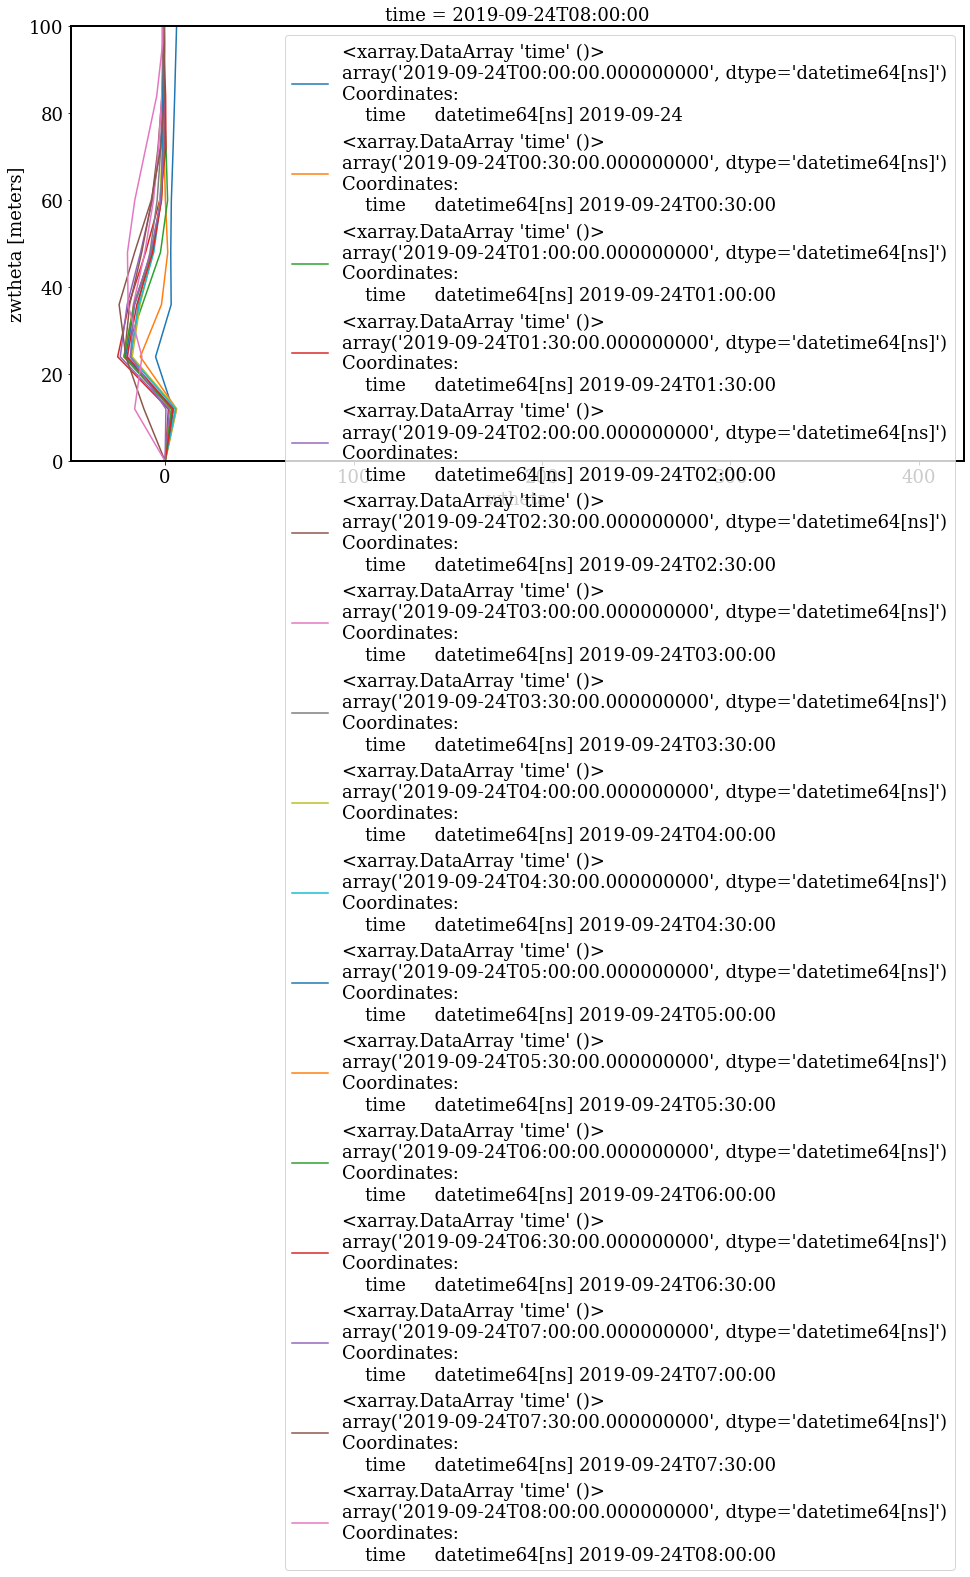

In [66]:
fig = plt.figure(figsize=(16,8))
ax1= fig.subplots(1,1)
for i in profile_ds_subset['wtheta'].time:
    profile_ds_subset.wtheta.sel(time=i).plot(y='zwtheta', ax=ax1, label=str(i))
    ax1.set_ylim([0,100])
    ax1.legend()
    

[########################################] | 100% Completed | 102.05 ms


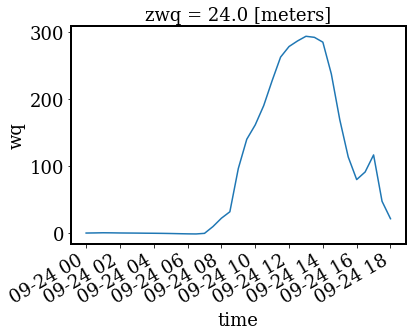

In [48]:
profile_ds.wq.sel(zwq=24,time=slice('2019-09-24T00:00:00.00000000','2019-09-24T18:15:00.00000000')).resample(time='30T').mean().plot()